This model is based on ResNet18 architecture, which is adapted from: https://github.com/TerryLiu007/ImageClassification/blob/b37b0921305666c06e7b3e85dbf6560536e02176/ResNet18.ipynb. 
With the rest of the code adapted from *1. Standard CNN* model.

The model achieves 61.8% accuracy on test data.

In [0]:
#import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image

from warnings import filterwarnings

np.random.seed(101)
filterwarnings('ignore')
sns.set_style('darkgrid')

**Setting data path**

In [0]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# copy file to colab directory
import shutil
shutil.copy2("drive/My Drive/ISIC/ISIC_2019_Training_Input.zip", "./")

'./ISIC_2019_Training_Input.zip'

In [0]:
!unzip -q ISIC_2019_Training_Input.zip

In [0]:
# create image path
base_loc = '/content/ISIC_2019_Training_Input'
image_paths = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_loc, '*.jpg'))}


In [0]:
%cd /content/ISIC_2019_Training_Input

/content/ISIC_2019_Training_Input


In [0]:
# merge csv file with image folder
df_skin = pd.read_csv(os.path.join(base_loc, '/content/drive/My Drive/ISIC/full.csv'))

,image,diagnosis,age_approx,anatom_site_general,lesion_id,sex,is_val
0,ISIC_0012756_downsampled,MEL,55.0,anterior torso,MSK4_0010029,male,0
1,ISIC_0012930_downsampled,MEL,70.0,posterior torso,MSK4_0010026,female,0
2,ISIC_0013184_downsampled,MEL,55.0,anterior torso,MSK4_0010029,male,0
3,ISIC_0013232_downsampled,MEL,70.0,posterior torso,MSK4_0010026,female,0
4,ISIC_0013274_downsampled,NV,65.0,anterior torso,MSK4_0010011,male,0


In [0]:
# create new column with path information of each lesion
df_skin['image_path'] = df_skin['image'].map(image_paths.get)
df_skin.head()

,image,diagnosis,age_approx,anatom_site_general,lesion_id,sex,is_val,image_path
0,ISIC_0012756_downsampled,MEL,55.0,anterior torso,MSK4_0010029,male,0,/content/ISIC_2019_Training_Input/ISIC_0012756...
1,ISIC_0012930_downsampled,MEL,70.0,posterior torso,MSK4_0010026,female,0,/content/ISIC_2019_Training_Input/ISIC_0012930...
2,ISIC_0013184_downsampled,MEL,55.0,anterior torso,MSK4_0010029,male,0,/content/ISIC_2019_Training_Input/ISIC_0013184...
3,ISIC_0013232_downsampled,MEL,70.0,posterior torso,MSK4_0010026,female,0,/content/ISIC_2019_Training_Input/ISIC_0013232...
4,ISIC_0013274_downsampled,NV,65.0,anterior torso,MSK4_0010011,male,0,/content/ISIC_2019_Training_Input/ISIC_0013274...


In [0]:
# there are 8 target classes
lesion_types = {
    'NV': 'Melanocytic nevi',
    'MEL': 'Melanoma',
    'BKL': 'Benign keratosis-like lesions ',
    'BCC': 'Basal cell carcinoma',
    'AK': 'Actinic keratoses',
    'VASC': 'Vascular lesions',
    'DF': 'Dermatofibroma',
    'SCC': 'Squamous cell carcinoma'}
df_skin['type'] = df_skin['diagnosis'].map(lesion_types.get)

# Converting the type to the categorical values
df_skin['type_id'] = pd.Categorical(df_skin['type']).codes

df_skin.head()

,image,diagnosis,age_approx,anatom_site_general,lesion_id,sex,is_val,image_path,type,type_id
0,ISIC_0012756_downsampled,MEL,55.0,anterior torso,MSK4_0010029,male,0,/content/ISIC_2019_Training_Input/ISIC_0012756...,Melanoma,5
1,ISIC_0012930_downsampled,MEL,70.0,posterior torso,MSK4_0010026,female,0,/content/ISIC_2019_Training_Input/ISIC_0012930...,Melanoma,5
2,ISIC_0013184_downsampled,MEL,55.0,anterior torso,MSK4_0010029,male,0,/content/ISIC_2019_Training_Input/ISIC_0013184...,Melanoma,5
3,ISIC_0013232_downsampled,MEL,70.0,posterior torso,MSK4_0010026,female,0,/content/ISIC_2019_Training_Input/ISIC_0013232...,Melanoma,5
4,ISIC_0013274_downsampled,NV,65.0,anterior torso,MSK4_0010011,male,0,/content/ISIC_2019_Training_Input/ISIC_0013274...,Melanocytic nevi,4


In [0]:
# merge the csv file containing the label with the array of images after resizing them to (100,75)
df_skin['skin_image'] = df_skin['image_path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [0]:
df_skin.head()

,image,diagnosis,age_approx,anatom_site_general,lesion_id,sex,is_val,image_path,type,type_id,skin_image
0,ISIC_0012756_downsampled,MEL,55.0,anterior torso,MSK4_0010029,male,0,/content/ISIC_2019_Training_Input/ISIC_0012756...,Melanoma,5,"[[[131, 122, 125], [147, 144, 153], [156, 151,..."
1,ISIC_0012930_downsampled,MEL,70.0,posterior torso,MSK4_0010026,female,0,/content/ISIC_2019_Training_Input/ISIC_0012930...,Melanoma,5,"[[[190, 162, 150], [193, 175, 165], [192, 174,..."
2,ISIC_0013184_downsampled,MEL,55.0,anterior torso,MSK4_0010029,male,0,/content/ISIC_2019_Training_Input/ISIC_0013184...,Melanoma,5,"[[[121, 114, 121], [140, 138, 151], [148, 147,..."
3,ISIC_0013232_downsampled,MEL,70.0,posterior torso,MSK4_0010026,female,0,/content/ISIC_2019_Training_Input/ISIC_0013232...,Melanoma,5,"[[[166, 125, 95], [166, 127, 94], [166, 141, 1..."
4,ISIC_0013274_downsampled,NV,65.0,anterior torso,MSK4_0010011,male,0,/content/ISIC_2019_Training_Input/ISIC_0013274...,Melanocytic nevi,4,"[[[38, 42, 54], [33, 34, 54], [65, 60, 67], [1..."


In [0]:
# set features and target
features = df_skin.drop(columns=['type_id'],axis=1)
target = df_skin['type_id']

**Splitting data in 80/20 ratio**

In [0]:
# using sklearn library to split the training and testing dataset in 80:20 ratio.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state = 101)
print('The length of training set is {}\nThe length of testing set is {}\nThe ratio is {}'.format(len(X_train), len(X_test), '80/20'))

The length of training set is 20264
The length of testing set is 5067
The ratio is 80/20


**Normalization**

In [0]:
X_train = np.asarray(X_train['skin_image'].tolist())
X_test = np.asarray(X_test['skin_image'].tolist())
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()

One Hot Encoding

In [0]:
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
y_train = to_categorical(y_train, num_classes= 8)
y_test = to_categorical(y_test, num_classes= 8)

In [0]:
print(X_train.shape)
print(X_test.shape)

(20264, 75, 100, 3)
(5067, 75, 100, 3)


**Proposed model - ResNet18**

model architecture adapted from: https://github.com/TerryLiu007/ImageClassification/blob/b37b0921305666c06e7b3e85dbf6560536e02176/ResNet18.ipynb


In [0]:
# import keras library
import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical
import keras
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Reshape
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation, Concatenate, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras import regularizers, initializers
from keras.layers.advanced_activations import LeakyReLU, ReLU, Softmax
from keras.utils import plot_model
from keras.models import load_model


In [0]:
# Dictionary of common parameters used in convolutional layers
params_conv2d = {
        "padding": "SAME",
        "activation": keras.activations.relu}

In [0]:
# Input tensor
x = keras.Input((75, 100, 3))

# conv_1: first convolution block with 32 filters and kernel size of (3,3), incorporating dropout to avoid over-fitting
conv1 = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, **params_conv2d)(x)
conv1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv1)

# conv_2_x: second block, starting with average pooling to reduce dimension of the input
ave_pool1 = keras.layers.AvgPool2D(padding="SAME")(conv1)
conv2_1 = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, **params_conv2d)(ave_pool1)
conv2_1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv2_1)
conv2_2 = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, **params_conv2d)(conv2_1)
conv2_2 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv2_2)
skip2_1 = keras.layers.BatchNormalization()(keras.layers.add([ave_pool1, conv2_2]))
# Batch normalization 
conv2_3 = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, **params_conv2d)(conv2_2)
conv2_3 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv2_3)
conv2_4 = keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, **params_conv2d)(conv2_3)
conv2_4 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv2_4)

resize2 = keras.layers.Conv2D(filters=32, kernel_size=1, strides=2, padding="SAME")(skip2_1)
skip2_2 = keras.layers.BatchNormalization()(keras.layers.add([resize2, conv2_4]))

# conv_3_x: third block
conv3_1 = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, **params_conv2d)(skip2_2)
conv3_1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv3_1)
conv3_2 = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, **params_conv2d)(conv3_1)
conv3_2 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv3_2)

resize3_1 = keras.layers.Conv2D(filters=64, kernel_size=1, strides=1, padding="SAME")(skip2_2)
skip3_1 = keras.layers.BatchNormalization()(keras.layers.add([resize3_1, conv3_2]))

conv3_3 = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, **params_conv2d)(skip3_1)
conv3_3 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv3_3)
conv3_4 = keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, **params_conv2d)(conv3_3)
conv3_4 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv3_4)

resize3_2 = keras.layers.Conv2D(filters=64, kernel_size=1, strides=2, padding="SAME")(skip3_1)
skip3_2 = keras.layers.BatchNormalization()(keras.layers.add([resize3_2, conv3_4]))

# conv_4_x
conv4_1 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, **params_conv2d)(skip3_2)
conv4_1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv4_1)
conv4_2 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, **params_conv2d)(conv4_1)
conv4_2 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv4_2)

resize4_1 = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1, padding="SAME")(skip3_2)
skip4_1 = keras.layers.BatchNormalization()(keras.layers.add([resize4_1, conv4_2]))

conv4_3 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, **params_conv2d)(skip4_1)
conv4_3 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv4_3)
conv4_4 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, **params_conv2d)(conv4_3)
conv4_4 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv4_4)

resize4_2 = keras.layers.Conv2D(filters=128, kernel_size=1, strides=2, padding="SAME")(skip4_1)
skip4_2 = keras.layers.BatchNormalization()(keras.layers.add([resize4_2, conv4_4]))

# conv_5_x
conv5_1 = keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, **params_conv2d)(skip4_2)
conv5_1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv5_1)
conv5_2 = keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, **params_conv2d)(conv5_1)
conv5_2 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv5_2)

resize5_1 = keras.layers.Conv2D(filters=256, kernel_size=1, strides=1, padding="SAME")(skip4_2)
skip5_1 = keras.layers.BatchNormalization()(keras.layers.add([resize5_1, conv5_2]))

conv5_3 = keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, **params_conv2d)(skip5_1)
conv5_3 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv5_3)
conv5_4 = keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, **params_conv2d)(conv5_3)
conv5_4 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv5_4)

resize5_2 = keras.layers.Conv2D(filters=256, kernel_size=1, strides=1, **params_conv2d)(skip5_1)
skip5_2 = keras.layers.BatchNormalization()(keras.layers.add([resize5_2, conv5_4]))

avg_pool = keras.layers.AvgPool2D(strides=2)(skip5_2)
flat = keras.layers.Flatten()(avg_pool)
dense8 = keras.layers.Dense(8)(flat)
softmax = keras.layers.Softmax()(dense8)

# The stem model from input which is represented as x is combined with the last layer which is softmax
model = keras.Model(inputs=x, outputs=softmax)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.











In [0]:
# To compile to model:
# Adam optimizer is used
# Since one-hot-ecoded vectors are used, the categorical cross entropy is used as loss and the metric is set to be top-1 accuracy
model.compile(Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# For each episode the input data is shuffled to create a different order for the inputs
# Batch size is set to be 32 meaning that there are 32 samples fed into the model per gradient update.
# 50 epochs mean that the model will be trained and iterated on the dataset for 50 times.
mod = model.fit(x = X_train, y = y_train, batch_size=32, shuffle=True, epochs= 50)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
20264/20264 [==============================] - 83s 4ms/step - loss: 1.4825 - acc: 0.5023
Epoch 2/50
20264/20264 [==============================] - 76s 4ms/step - loss: 1.3164 - acc: 0.5368
Epoch 3/50
20264/20264 [==============================] - 76s 4ms/step - loss: 1.2664 - acc: 0.5514
Epoch 4/50
20264/20264 [==============================] - 76s 4ms/step - loss: 1.2328 - acc: 0.5635
Epoch 5/50
20264/20264 [==============================] - 76s 4ms/step - loss: 1.2119 - acc: 0.5666
Epoch 6/50
20264/20264 [==============================] - 76s 4ms/step - loss: 1.1998 - acc: 0.5732
Epoch 7/50
20264/20264 [==============================] - 76s 4ms/step - loss: 1.1812 - acc: 0.5802
Epoch 8/50
20264/20264 [==============================] - 76s 4ms/step - loss: 1.1712 - acc: 0.5823
Epoch 9/50
20264/20264 [==============================] - 76s 4ms/step - loss: 1.1548 - acc: 0.5869
Ep

In [0]:
model.save('skin.cr')

**Evaluation**

In [0]:
# Evaluate the accuracy and loss of the model on test dataset
# https://keras.io/models/model/#evaluate
loss,acc = model.evaluate(X_test, y_test)
print("The accuracy of the model is {:.3f}\nThe loss in the model is {:.3f}".format(acc,loss))

5067/5067 [==============================] - 5s 898us/step
The accuracy of the model is 0.618
The loss in the model is 1.059


**The subsequent evaluation is not reflected in the report because this CNN model is not the top-performing one.**

It is left in the code just in case you are interested.

In [0]:
from keras.models import load_model
import itertools
from sklearn.metrics import confusion_matrix, classification_report
model = load_model('skin.cr')

In [0]:
# Function to plot confusion matrix
# Taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix_normalized(cm, classes,
                          normalize=True,
                          title='Normalized confusion matrix',
                          cmap=plt.cm.Blues):
    # compute confusion matrix - this function plots normalized confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    # All ticks are shown
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Put respective labels on the plot
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid(None)

In [0]:
# this function shows non-normalized confusion matrix
def plot_confusion_matrix_nonnormalized(cm, classes,
                          normalize=False,
                          title='Non-normalized confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid(None)

In [0]:
# Using the model to generate predictions
predictions = model.predict(X_test)
# Predictions are converted to one hot vectors.
y_pred = np.argmax(predictions,axis = 1) 

In [0]:
# Target label is converted to one hot vectors
y_true = np.argmax(y_test,1)

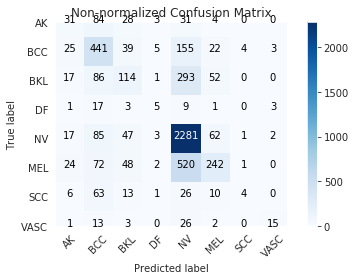

Normalized confusion matrix


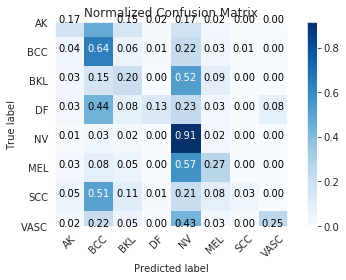

In [0]:
cm = confusion_matrix(y_true, y_pred)
classes = ['AK','BCC','BKL','DF','NV','MEL','SCC','VASC']

# Plot non-normalized confusion matrix
plot_confusion_matrix_nonnormalized(cm, classes)
plt.show()

# Plot normalized confusion matrix
plot_confusion_matrix_normalized(cm, classes)
plt.show()

In [0]:
report = classification_report(y_true, y_pred, target_names=classes)
print(report)

              precision    recall  f1-score   support

          AK       0.25      0.17      0.20       181
         BCC       0.51      0.64      0.57       694
         BKL       0.39      0.20      0.27       563
          DF       0.25      0.13      0.17        39
          NV       0.68      0.91      0.78      2498
         MEL       0.61      0.27      0.37       909
         SCC       0.40      0.03      0.06       123
        VASC       0.65      0.25      0.36        60

    accuracy                           0.62      5067
   macro avg       0.47      0.32      0.35      5067
weighted avg       0.59      0.62      0.57      5067



**Visualizing Curves**

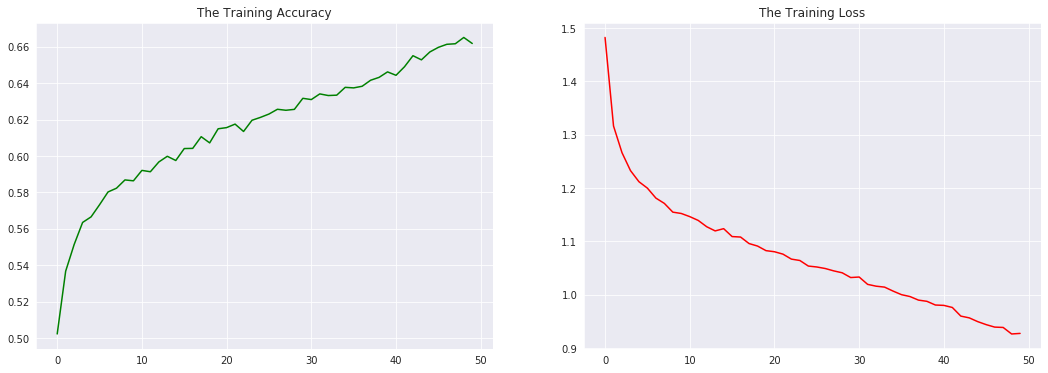

In [0]:
# Visualize the change in training accuracy and loss in the 50 epochs
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(mod.history['acc'], color = 'green')
plt.title('The Training Accuracy')
plt.subplot(1,2,2)
plt.plot(mod.history['loss'], color = 'red')
plt.title('The Training Loss')
plt.show()

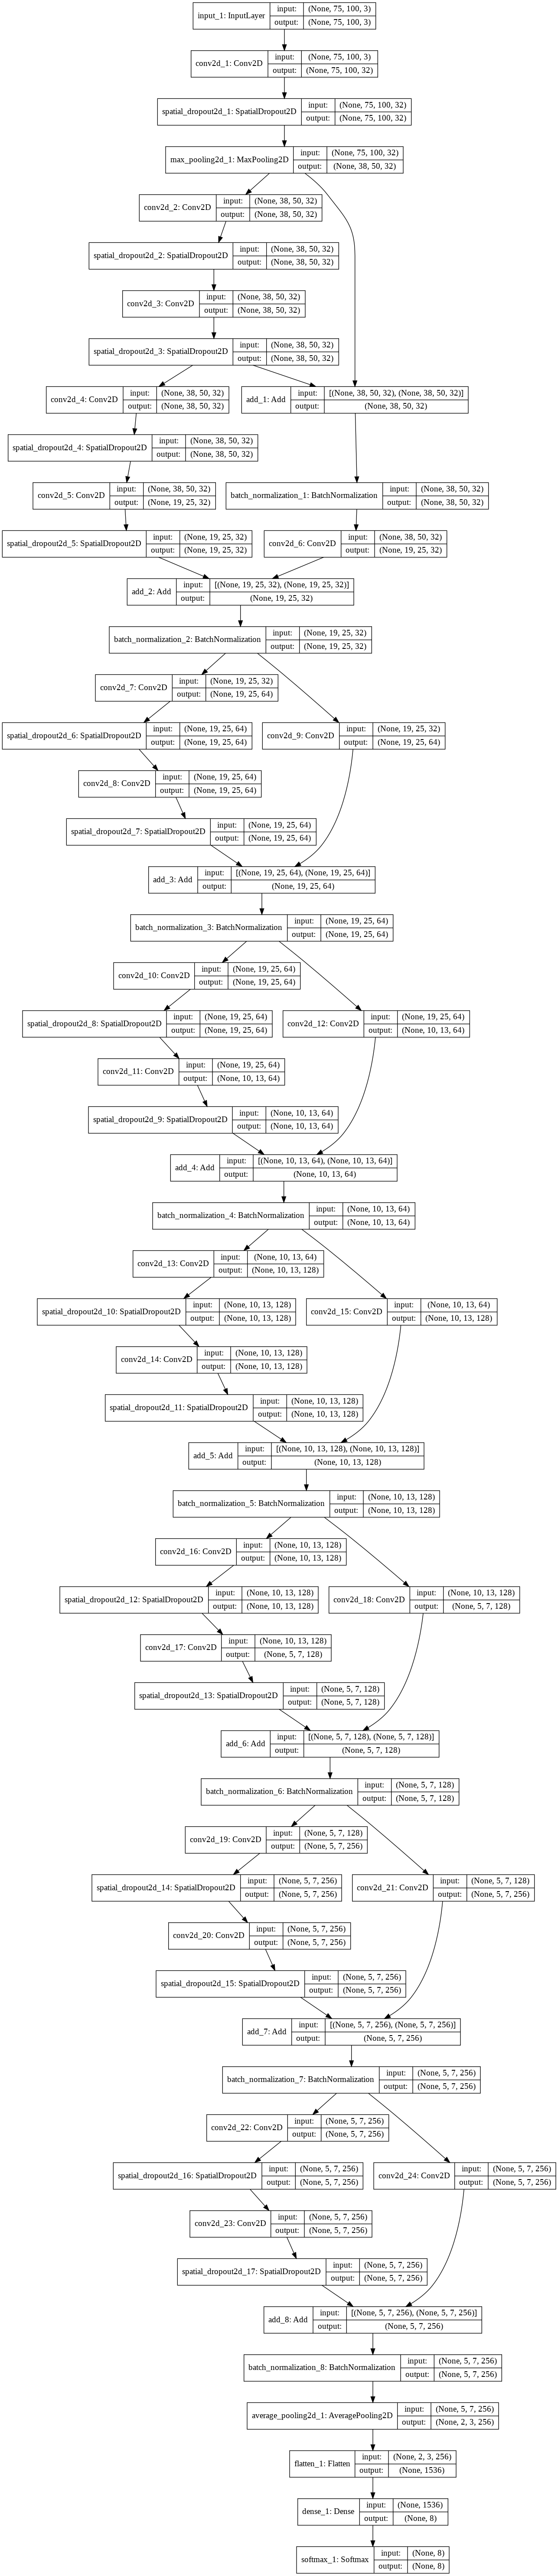

In [0]:
# model architecture plot
plot_model(model, to_file='Resnet18_model_plot.png', show_shapes=True, show_layer_names=True)

**Case specific evaluation**
Adapted from: https://github.com/pegahbyte/deep_learning_image_classification/blob/master/SkinCancerClassification_Project.ipynb

In [0]:
def cancer_detection(model, threshold=0.5):
    '''This function returns the confusion matrix for
    binary cancer detection for a given model and threshold'''
    
    # Define target 1,5 and 6 as dangerous cancer lesions
    # and the other 5 groups as benign
    y_true=[1 if np.argmax(y_test[i]) in [1,5,6] else 0 for i in range(len(y_test))]
    # Predict the values from the test dataset
    y_pred = model.predict(X_test)
    y_pred=[1 if y_pred[i][1]+y_pred[i][5]+y_pred[i][6] > threshold else 0 for i in range(len(y_test))]
    confusion_mtrx=confusion_matrix(y_true,y_pred)
    return(confusion_mtrx)  

def melanoma_detection(model, threshold=0.5):
    '''This function returns the confusion matrix for
    binary melanom detection for a given model and threshold'''
    # Define target 5 as melanoma lesions
    # and the other 7 groups as non-melanoma lesions
    y_true=[1 if np.argmax(y_test[i]) in [5] else 0 for i in range(len(y_test))]
    # Predict the values from the test dataset
    y_pred = model.predict(X_test)
    y_pred=[1 if y_pred[i][5] > threshold else 0 for i in range(len(y_test))]
    confusion_mtrx=confusion_matrix(y_true,y_pred)
    return(confusion_mtrx)

In [0]:
model_cd = cancer_detection(model)
print(model_cd)
acccd=(model_cd[0,0]+model_cd[1,1])/(sum(sum(model_cd)))
fncd=model_cd[1,0]/sum(model_cd)[1]
fpcd=model_cd[0,1]/sum(model_cd)[0]
print("For the model, the cancer binary-accuracy is", acccd, "\nThe false positive rate is", fpcd,"and the false negative rate is",
     fncd)

[[3060  281]
 [ 992  734]]
For the model, the cancer binary-accuracy is 0.7487665285178606 
The false positive rate is 0.06934846989141165 and the false negative rate is 0.9773399014778326


In [0]:
model_md = melanoma_detection(model)
print(model_md)
accmd=(model_md[0,0]+model_md[1,1])/(sum(sum(model_md)))
fnmd=model_md[1,0]/sum(model_md)[1]
fpmd=model_md[0,1]/sum(model_md)[0]
print("For the model, the melanoma binary-accuracy is", accmd, "\nThe false positive rate is", fpmd,"and the false negative rate is",
     fnmd)

[[4119   39]
 [ 796  113]]
For the model, the melanoma binary-accuracy is 0.8352082099861852 
The false positive rate is 0.007934893184130213 and the false negative rate is 5.2368421052631575


**Adaptive threshold**

In [0]:
thresholds=np.arange(0, 1, 0.05)
resultsFN=[]
resultsFP=[]
costs=[]
for t in thresholds:
    results=cancer_detection(model, t)
    resultsFN.append(results[1,0])
    resultsFP.append(results[0,1])

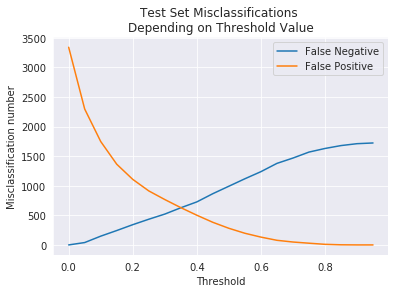

In [0]:
# plot misclassification number against threshold value
plt.plot(thresholds,resultsFN, label="False Negative")
plt.plot(thresholds,resultsFP, label="False Positive")
plt.xlabel('Threshold')
plt.ylabel('Misclassification number')
plt.legend()
plt.title("Test Set Misclassifications \nDepending on Threshold Value");

<function matplotlib.pyplot.imshow>

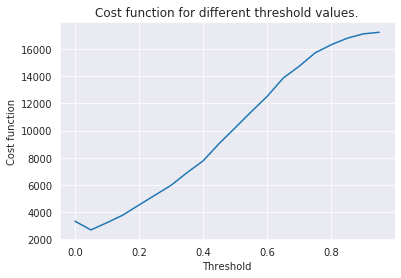

In [0]:
def costs(fn, fp, costFP=1, costFN=10):
    '''Calculates the "cost" of misclassification errors'''
    cost=[fn[i]*costFN+costFP*fp[i] for i in range(len(fn))]
    return(cost)

costs=costs(resultsFN,resultsFP)
plt.plot(thresholds,costs, label="Costs") 
plt.title("Cost function for different threshold values.")
plt.xlabel('Threshold')
plt.ylabel('Cost function')
plt.imshow